<a href="https://colab.research.google.com/github/Nethmi-Randi/AudioVideoSentimentAnalysis/blob/main/comparisionModule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opencv-python moviepy numpy


Python Script to compare audio and visual sentiments of a given video ( with spectrogram and Frames )


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


Video Duration: 7.5 seconds
1/1 [==============================] - 0s 45ms/step


  return pitch_tuning(



1/1 [==============================] - 0s 41ms/step
Image Sentiments:  ['Angry', 'Angry', 'Angry', 'Angry', 'Neutral', 'Neutral', 'Neutral', 'Angry']
Audio Sentiments:  ['angry', 'angry', 'angry', 'disgust', 'angry', 'disgust', 'disgust', 'angry']
Similarity Percentage: 50.0%
The audio and visual sentiments are similar.


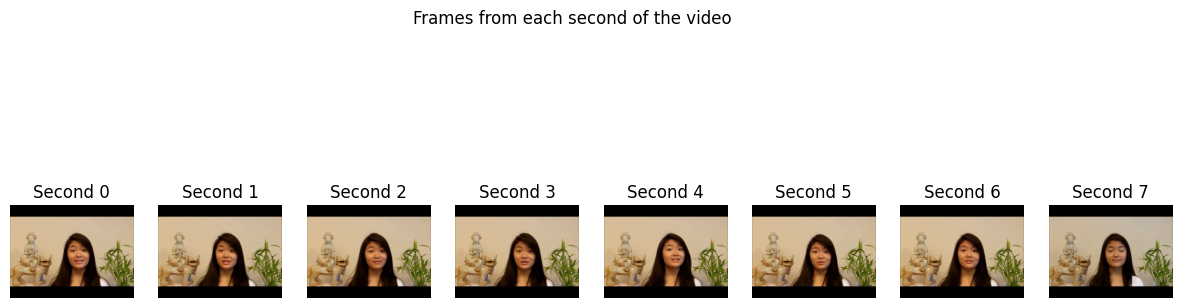

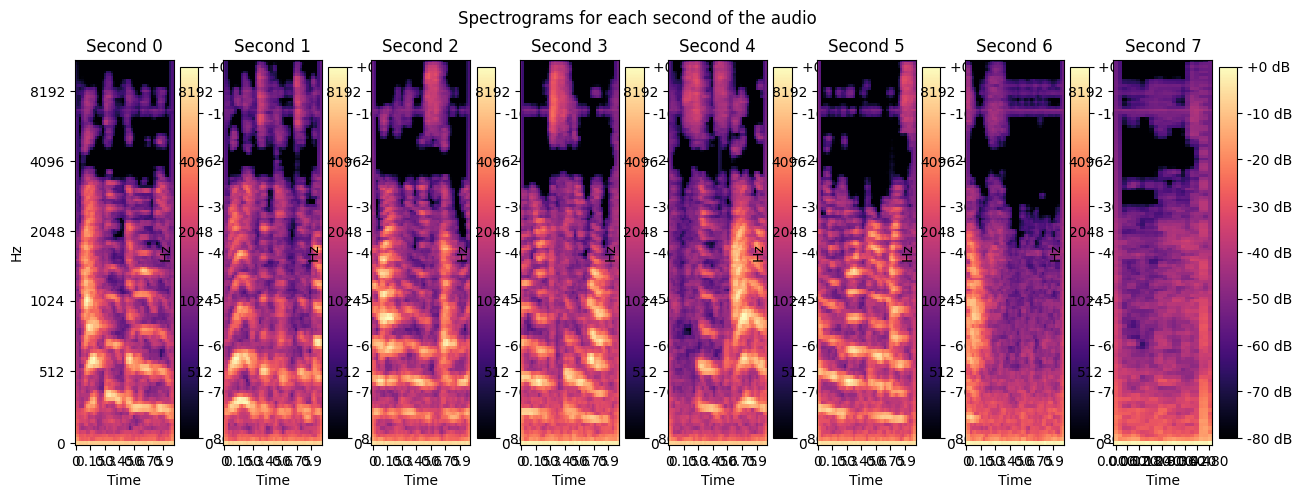

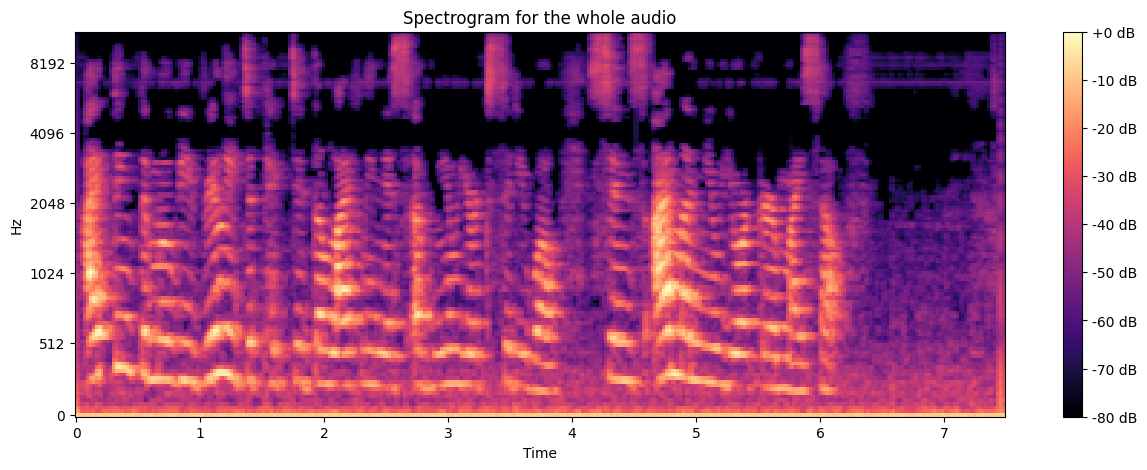

In [ ]:
import os
import numpy as np
import cv2
import librosa
import librosa.display
import moviepy.editor as mp
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pickle
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths to your models and scaler in Google Drive
image_model_path = '/content/drive/My Drive/models/Image.h5'
audio_model_path = '/content/drive/MyDrive/models/mau.h5'
scaler_path = '/content/drive/MyDrive/audio_scaler.pkl'

# Load the image sentiment analysis model
image_model = load_model(image_model_path)

# Load the audio classifier and scaler
def load_classifier(model_path, scaler_path):
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    classifier = load_model(model_path)
    return scaler, classifier

scaler, audio_model = load_classifier(audio_model_path, scaler_path)

# Function to extract frames and audio from video
def process_video(video_path):
    # Load video
    video = mp.VideoFileClip(video_path)

    # Extract audio
    audio = video.audio
    audio_path = "temp_audio.wav"
    audio.write_audiofile(audio_path)

    # Extract frames
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frames = []
    success, image = cap.read()
    while success:
        frames.append(image)
        for _ in range(int(fps) - 1):  # Skip frames to get 1 frame per second
            success, image = cap.read()
        success, image = cap.read()
    cap.release()

    return frames, audio_path

# Function to predict image sentiments
def predict_image_sentiments(frames):
    sentiments = []
    for frame in frames:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        frame = cv2.resize(frame, (48, 48))  # Adjust size as required by your model
        frame = img_to_array(frame)
        frame = np.expand_dims(frame, axis=0) / 255.0  # Normalize the image array
        prediction = image_model.predict(frame)

        # Mapping indices to emotion labels
        emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
        predicted_index = np.argmax(prediction)
        predicted_emotion = emotion_labels[predicted_index]

        sentiments.append(predicted_emotion)
    return sentiments

# Extract audio features by segment
def extract_features_segment(audio_segment, sample_rate):
    result = np.array([])

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio_segment).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma Shift
    stft = np.abs(librosa.stft(audio_segment))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=audio_segment, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=audio_segment).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=audio_segment, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result

# Predict sentiment
def predict_audio_sentiment(audio_file, scaler, classifier, sample_rate=22050):
    emotions = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
    audio, _ = librosa.load(audio_file, sr=sample_rate)
    duration = librosa.get_duration(y=audio, sr=sample_rate)
    total_seconds = int(np.ceil(duration))
    sentiments = []

    previous_sentiment_label = 'neutral'  # Default sentiment
    for second in range(total_seconds):
        start_sample = second * sample_rate
        end_sample = start_sample + sample_rate

        if end_sample > len(audio):
            end_sample = len(audio)

        segment = audio[start_sample:end_sample]

        if len(segment) > 0:
            features = extract_features_segment(segment, sample_rate)
            features_scaled = scaler.transform(features.reshape(1, -1))
            sentiment = classifier.predict(features_scaled)[0]
            sentiment_label = emotions[np.argmax(sentiment)]
            previous_sentiment_label = sentiment_label  # Update the previous sentiment
        else:
            sentiment_label = previous_sentiment_label  # Assign the previous sentiment if no sound

        sentiments.append(sentiment_label)

    return sentiments, duration


# Function to map image and audio sentiments
def map_sentiments(image_sentiment):
    sentiment_map = {
        'Angry': 'angry',
        'Disgust': 'disgust',
        'Fear': 'fearful',
        'Happy': 'happy',
        'Sad': 'sad',
        'Surprise': 'surprised',
        'Neutral': 'neutral'

    }
    return sentiment_map.get(image_sentiment, image_sentiment)

# Function to calculate similarity
def calculate_similarity(image_sentiments, audio_sentiments):
    matches = 0
    for i, image_sentiment in enumerate(image_sentiments):
        audio_sentiment = audio_sentiments[i] if i < len(audio_sentiments) else None
        if audio_sentiment and map_sentiments(image_sentiment) == audio_sentiment:
            matches += 1
    return (matches / len(image_sentiments)) * 100

# Function to display images and spectrograms
def display_images_and_spectrograms(frames, audio_file, sample_rate=22050):
    audio, _ = librosa.load(audio_file, sr=sample_rate)
    total_seconds = len(frames)

    # Plot images
    plt.figure(figsize=(15, 5))
    for second in range(total_seconds):
        plt.subplot(1, total_seconds, second + 1)
        plt.imshow(cv2.cvtColor(frames[second], cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Second {second}')
    plt.suptitle('Frames from each second of the video')
    plt.show()

    # Plot spectrograms for each second
    plt.figure(figsize=(15, 5))
    for second in range(total_seconds):
        start_sample = second * sample_rate
        end_sample = start_sample + sample_rate

        if end_sample > len(audio):
            end_sample = len(audio)

        segment = audio[start_sample:end_sample]
        S = librosa.feature.melspectrogram(y=segment, sr=sample_rate)
        S_DB = librosa.power_to_db(S, ref=np.max)

        plt.subplot(1, total_seconds, second + 1)
        librosa.display.specshow(S_DB, sr=sample_rate, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Second {second}')
    plt.suptitle('Spectrograms for each second of the audio')
    plt.show()

    # Plot the whole audio spectrograma
    plt.figure(figsize=(15, 5))
    S = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram for the whole audio')
    plt.show()

# Main function
def main(video_path, threshold=50):
    frames, audio_path = process_video(video_path)

    # Get video duration
    video = mp.VideoFileClip(video_path)
    video_duration = video.duration
    print(f"Video Duration: {video_duration} seconds")

    image_sentiments = predict_image_sentiments(frames)
    audio_sentiments, _ = predict_audio_sentiment(audio_path, scaler, audio_model)

    print("Image Sentiments: ", image_sentiments)
    print("Audio Sentiments: ", audio_sentiments)

    similarity_percentage = calculate_similarity(image_sentiments, audio_sentiments)
    print(f"Similarity Percentage: {similarity_percentage}%")

    if similarity_percentage >= threshold:
        print("The audio and visual sentiments are similar.")
    else:
        print("The audio and visual sentiments are not similar.")

   # Display images and spectrograms
    display_images_and_spectrograms(frames, audio_path)

video_path = '/content/drive/My Drive/customData/1/9c67fiY0wGQ_3.mp4'  # video path
main(video_path)


Python script to check the similarity of Audio and Visual parts of a given video

In [ ]:
import os
import numpy as np
import cv2
import librosa
import librosa.display
import moviepy.editor as mp
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pickle
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths to your models and scaler in Google Drive
image_model_path = '/content/drive/My Drive/models/Image.h5'
audio_model_path = '/content/drive/MyDrive/models/mau.h5'
scaler_path = '/content/drive/MyDrive/audio_scaler.pkl'

# Load the image sentiment analysis model
image_model = load_model(image_model_path)

# Load the audio classifier and scaler
def load_classifier(model_path, scaler_path):
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    classifier = load_model(model_path)
    return scaler, classifier

scaler, audio_model = load_classifier(audio_model_path, scaler_path)

# extract frames and audio from video
def process_video(video_path):
    # Load video
    video = mp.VideoFileClip(video_path)

    # Extract audio
    audio = video.audio
    audio_path = "temp_audio.wav"
    audio.write_audiofile(audio_path)

    # Extract frames
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frames = []
    success, image = cap.read()
    while success:
        frames.append(image)
        for _ in range(int(fps) - 1):  # Skip frames to get 1 frame per second
            success, image = cap.read()
        success, image = cap.read()
    cap.release()

    return frames, audio_path

# Function to predict image sentiments
def predict_image_sentiments(frames):
    sentiments = []
    for frame in frames:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        frame = cv2.resize(frame, (48, 48))  # Adjust size as required by your model
        frame = img_to_array(frame)
        frame = np.expand_dims(frame, axis=0) / 255.0  # Normalize the image array
        prediction = image_model.predict(frame)

        # Mapping indices to emotion labels
        emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
        predicted_index = np.argmax(prediction)
        predicted_emotion = emotion_labels[predicted_index]

        sentiments.append(predicted_emotion)
    return sentiments

# Extract audio features by segment
def extract_features_segment(audio_segment, sample_rate):
    result = np.array([])

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio_segment).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma Shift
    stft = np.abs(librosa.stft(audio_segment))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=audio_segment, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=audio_segment).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=audio_segment, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result

# Predict sentiment
def predict_audio_sentiment(audio_file, scaler, classifier, sample_rate=22050):
    emotions = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
    audio, _ = librosa.load(audio_file, sr=sample_rate)
    duration = librosa.get_duration(y=audio, sr=sample_rate)
    total_seconds = int(np.ceil(duration))
    sentiments = []

    previous_sentiment_label = 'neutral'  # Default sentiment

    for second in range(total_seconds):
        start_sample = second * sample_rate
        end_sample = start_sample + sample_rate

        if end_sample > len(audio):
            end_sample = len(audio)

        segment = audio[start_sample:end_sample]

        if len(segment) > 0:
            features = extract_features_segment(segment, sample_rate)
            features_scaled = scaler.transform(features.reshape(1, -1))
            sentiment = classifier.predict(features_scaled)[0]
            sentiment_label = emotions[np.argmax(sentiment)]
            previous_sentiment_label = sentiment_label  # Update the previous sentiment
        else:
            sentiment_label = previous_sentiment_label  # Assign the previous sentiment if no sound

        sentiments.append(sentiment_label)

    return sentiments, duration


# map image and audio sentiments
def map_sentiments(image_sentiment):
    sentiment_map = {
        'Angry': 'angry',
        'Disgust': 'disgust',
        'Fear': 'fearful',
        'Happy': 'happy',
        'Sad': 'sad',
        'Surprise': 'surprised',
        'Neutral': 'neutral'
    }
    return sentiment_map.get(image_sentiment, image_sentiment)

# calculate similarity
def calculate_similarity(image_sentiments, audio_sentiments):
    matches = 0
    for i, image_sentiment in enumerate(image_sentiments):
        audio_sentiment = audio_sentiments[i] if i < len(audio_sentiments) else None
        if audio_sentiment and map_sentiments(image_sentiment) == audio_sentiment:
            matches += 1
    return (matches / len(image_sentiments)) * 100

# Main function
def main(video_path, threshold=50):
    frames, audio_path = process_video(video_path)

    # Get video duration
    video = mp.VideoFileClip(video_path)
    video_duration = video.duration
    print(f"Video Duration: {video_duration} seconds")

    image_sentiments = predict_image_sentiments(frames)
    audio_sentiments, _ = predict_audio_sentiment(audio_path, scaler, audio_model)

    print("Image Sentiments: ", image_sentiments)
    print("Audio Sentiments: ", audio_sentiments)

    similarity_percentage = calculate_similarity(image_sentiments, audio_sentiments)
    print(f"Similarity Percentage: {similarity_percentage}%")

    if similarity_percentage >= threshold:
        print("The audio and visual sentiments are similar.")
    else:
        print("The audio and visual sentiments are not similar.")


video_path = '/content/drive/My Drive/customData/1/zhpQhgha_KU_16.mp4'  #  video path
main(video_path)


Mounted at /content/drive
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


Video Duration: 3.83 seconds
1/1 [==============================] - 0s 36ms/step
Image Sentiments:  ['Fear', 'Angry', 'Angry', 'Angry']
Audio Sentiments:  ['angry', 'angry', 'angry', 'angry']
Similarity Percentage: 75.0%
The audio and visual sentiments are similar.


getting confusion matrics for prediction model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 44ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 35ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 35ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 32ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 34ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 61ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.
1/1 [==============================] - 0s 36ms/step


  warnings.warn(



1/1 [==============================] - 0s 38ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 35ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 47ms/step
MoviePy - Writing audio in temp_audio.wav


chunk:  93%|█████████▎| 378/408 [00:00<00:00, 1573.78it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/audio/io/readers.py:197: UserWarning: Error in file /content/drive/My Drive/customData/0/8d-gEyoeBzc_21.mp4, At time t=18.45-18.50 seconds, indices wanted: 99661-101660, but len(buffer)=99662
index 99662 is out of bounds for axis 0 with size 99662
  warnings.warn("Error in file %s, "%(self.filename)+



MoviePy - Done.
1/1 [==============================] - 0s 61ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 37ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 36ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 45ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.
1/1 [==============================] - 0s 34ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 48ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 37ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 36ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 37ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 43ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 42ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 34ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 128ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 40ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 35ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 33ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 34ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 42ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 33ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 36ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 36ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 38ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.
1/1 [==============================] - 0s 35ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 43ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 38ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 47ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 36ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 41ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 55ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 54ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 34ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 42ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 37ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.
1/1 [==============================] - 0s 32ms/step


  warnings.warn(



1/1 [==============================] - 0s 32ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 39ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 37ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 39ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 42ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 32ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 45ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 39ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 37ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 46ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 44ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 46ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 39ms/step


  warnings.warn(



1/1 [==============================] - 0s 43ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 33ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 38ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 45ms/step


  warnings.warn(



1/1 [==============================] - 0s 37ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 55ms/step


  warnings.warn(



1/1 [==============================] - 0s 35ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 33ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 36ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 39ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 35ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 34ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 43ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 33ms/step


  return pitch_tuning(



1/1 [==============================] - 0s 41ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 58ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 39ms/step


  warnings.warn(



1/1 [==============================] - 0s 33ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 40ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 38ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 42ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.
1/1 [==============================] - 0s 36ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 39ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 33ms/step


  warnings.warn(



1/1 [==============================] - 0s 36ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 39ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 44ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 33ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 37ms/step


  warnings.warn(



1/1 [==============================] - 0s 40ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 40ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 38ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 41ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 38ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 223ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.
1/1 [==============================] - 0s 58ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 66ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 37ms/step


  warnings.warn(



1/1 [==============================] - 0s 37ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 36ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 90ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 45ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 35ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 43ms/step


  warnings.warn(



1/1 [==============================] - 0s 39ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 39ms/step


  warnings.warn(



1/1 [==============================] - 0s 41ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 37ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 38ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 33ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 36ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 37ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 46ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.
1/1 [==============================] - 0s 37ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 33ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.
1/1 [==============================] - 0s 41ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.
1/1 [==============================] - 0s 41ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 37ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 43ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 41ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 51ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 35ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 39ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 40ms/step
MoviePy - Writing audio in temp_audio.wav


MoviePy - Done.


1/1 [==============================] - 0s 33ms/step
Confusion Matrix:
[[36 19]
 [30 25]]
Accuracy: 0.5545454545454546
Precision: 0.5681818181818182
Recall: 0.45454545454545453
F1 Score: 0.5050505050505051


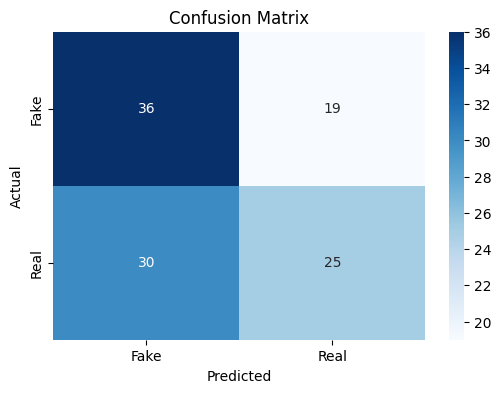

In [ ]:
import os
import numpy as np
import cv2
import librosa
import moviepy.editor as mp
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import pickle
from google.colab import drive
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive
drive.mount('/content/drive')

# Paths to your models and scaler in Google Drive
image_model_path = '/content/drive/My Drive/models/Image.h5'
audio_model_path = '/content/drive/MyDrive/models/mau.h5'
scaler_path = '/content/drive/MyDrive/audio_scaler.pkl'

# Load the image sentiment analysis model
image_model = load_model(image_model_path)

# Load the audio classifier and scaler
def load_classifier(model_path, scaler_path):
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    classifier = load_model(model_path)
    return scaler, classifier

scaler, audio_model = load_classifier(audio_model_path, scaler_path)

# Function to extract frames and audio from video
def process_video(video_path):
    # Load video
    video = mp.VideoFileClip(video_path)

    # Extract audio
    audio = video.audio
    audio_path = "temp_audio.wav"
    audio.write_audiofile(audio_path)

    # Extract frames
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frames = []
    success, image = cap.read()
    while success:
        frames.append(image)
        for _ in range(int(fps) - 1):  # Skip frames to get 1 frame per second
            success, image = cap.read()
        success, image = cap.read()
    cap.release()

    return frames, audio_path

# Function to predict image sentiments
def predict_image_sentiments(frames):
    sentiments = []
    for frame in frames:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        frame = cv2.resize(frame, (48, 48))  # Adjust size as required by your model
        frame = img_to_array(frame)
        frame = np.expand_dims(frame, axis=0) / 255.0  # Normalize the image array
        prediction = image_model.predict(frame)

        # Mapping indices to emotion labels
        emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
        predicted_index = np.argmax(prediction)
        predicted_emotion = emotion_labels[predicted_index]

        sentiments.append(predicted_emotion)
    return sentiments

# Extract audio features by segment
def extract_features_segment(audio_segment, sample_rate):
    result = np.array([])

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio_segment).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma Shift
    stft = np.abs(librosa.stft(audio_segment))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=audio_segment, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=audio_segment).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=audio_segment, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result

# Predict sentiment
def predict_audio_sentiment(audio_file, scaler, classifier, sample_rate=22050):
    emotions = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
    audio, _ = librosa.load(audio_file, sr=sample_rate)
    duration = librosa.get_duration(y=audio, sr=sample_rate)
    total_seconds = int(np.ceil(duration))
    sentiments = []

    for second in range(total_seconds):
        start_sample = second * sample_rate
        end_sample = start_sample + sample_rate

        if end_sample > len(audio):
            end_sample = len(audio)

        segment = audio[start_sample:end_sample]

        if len(segment) > 0:
            features = extract_features_segment(segment, sample_rate)
            features_scaled = scaler.transform(features.reshape(1, -1))
            sentiment = classifier.predict(features_scaled)[0]
            sentiment_label = emotions[np.argmax(sentiment)]
        else:
            sentiment_label = None

        sentiments.append(sentiment_label)

    return sentiments, duration

# Function to map image and audio sentiments
def map_sentiments(image_sentiment):
    sentiment_map = {
        'Angry': 'angry',
        'Disgust': 'disgust',
        'Fear': 'fearful',
        'Happy': 'happy',
        'Sad': 'sad',
        'Surprise': 'surprised',
        'Neutral': 'neutral',
    }
    return sentiment_map.get(image_sentiment, image_sentiment)

# calculate similarity
def calculate_similarity(image_sentiments, audio_sentiments):
    matches = 0
    for i, image_sentiment in enumerate(image_sentiments):
        audio_sentiment = audio_sentiments[i] if i < len(audio_sentiments) else None
        if audio_sentiment and map_sentiments(image_sentiment) == audio_sentiment:
            matches += 1
    return (matches / len(image_sentiments)) * 100

# Main function
def main(video_path):
    frames, audio_path = process_video(video_path)

    image_sentiments = predict_image_sentiments(frames)
    audio_sentiments, _ = predict_audio_sentiment(audio_path, scaler, audio_model)

    similarity_percentage = calculate_similarity(image_sentiments, audio_sentiments)

    return similarity_percentage

# Process the dataset
def process_dataset(dataset_path):
    true_labels = []
    predicted_labels = []
    for label in ['0', '1']:
        folder_path = os.path.join(dataset_path, label)
        for video_file in os.listdir(folder_path):
            video_path = os.path.join(folder_path, video_file)
            similarity_percentage = main(video_path)
            true_labels.append(1 if label == '1' else 0)  # Real videos have label 1, fake videos have label 0
            predicted_labels.append(1 if similarity_percentage >= 50 else 0)

    return true_labels, predicted_labels

# Evaluate the model
dataset_path = '/content/drive/My Drive/customData'  # dataset path
true_labels, predicted_labels = process_dataset(dataset_path)

# Calculate metrics
conf_matrix = confusion_matrix(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print metrics
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
